In [44]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import nibabel as nib
import scipy.io as sio
from scipy import ndimage as nd
from scipy.io import loadmat
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import src.pyNumpyUtility as pnu
import src.pyFWRF as prf
from src.pyFWRF import FWRF_model, fpX

In [11]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
input_dir  = root_dir+"output/"
output_dir = root_dir+"results/"


print "Time Stamp: %s" % timestamp

Time Stamp: Mar-22-2017_0012


## Choose the plotting style

In [3]:
sns.axes_style()
#sns.plotting_context()
print sns.color_palette("hls")


[(0.86, 0.37119999999999997, 0.33999999999999997), (0.82879999999999987, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.37119999999999997), (0.33999999999999997, 0.82879999999999987, 0.86), (0.37119999999999997, 0.33999999999999997, 0.86), (0.86, 0.33999999999999997, 0.82879999999999987)]


In [4]:
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

# 1b) Load the corresponding voxel data

In [5]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

voxelset = h5py.File(dataset_dir+"EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [6]:
subject = 'S1'

trn_size = 1750
val_size = 120

roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']
roi_markers = ['o', 's', '^', 'D', 'v', '<', '>', '*']
roi_group0 = [[0], [1], [2], [3], [4], [5], [6], [7]]
roi_group1 = [[0], [1], [2], [3], [4, 5, 6, 7]]
roi_group2 = [[0], [1, 2, 3], [4, 5, 6, 7]]
roi_group3 = [[1], [2], [3, 4, 5], [6], [7]]
roi_group4 = [[1], [2], [3], [6], [7]]
roi_dorsal  = [[1], [3], [4], [5]]
roi_ventral = [[1], [2], [6], [7]]
roi_vendrodorsal = [[7], [6], [2], [1], [3], [4], [5], [0]]

def iterate_roi(group, voxelroi, names):
    for g in group:
        g_name = ''
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            g_name += names[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

In [7]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape


# purge all voxel that have no variance in the validation set

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [8]:
voxelData = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxelData.shape

trnVoxelData = voxelData[:trn_size]
valVoxelData = voxelData[trn_size:]

(1870, 22701)


# 1c) Load the anatomical mask (we don't need it here)

In [9]:
def load_mask_from_nii(mask_nii_file):
    return nib.load(mask_nii_file).get_data()
    
def view_data(vol_shape, idx_mask, data_vol, save_to=None):
    view_vol = np.zeros(np.prod(vol_shape), dtype=np.float32)
    view_vol[idx_mask.astype('int').flatten()] = data_vol
    view_vol = view_vol.reshape(vol_shape, order='F')
    if save_to:
        nib.save(nib.Nifti1Image(view_vol, affine=np.eye(4)), save_to)
    return view_vol

In [10]:
anatomical_mask = load_mask_from_nii(dataset_dir+"Sub1_Anat_msk.nii.gz")

# 2a) LOAD THE RESULTS FOR MODEL 1

In [12]:
m1_name = 'refnet'

file_name = 'fwrf_S1_Mar-21-2017_1717_data'# 'refnet_fwrf/fwrf_model_S2_Mar-03-2017_0036' #'fwrf_model_S1_Feb-24-2017_1651_superdense_small_rf_size'
part_name = 'fwrf_S1_Mar-21-2017_1717_part' #'refnet_fwrf/fwrf_part_S2_Mar-03-2017_0036'

data_file = open(input_dir + "%s.pkl" % file_name, 'rb')
part_file = open(input_dir + "%s.pkl" % part_name, 'rb')
m1_data_dict = pickle.load(data_file)
m1_part_dict = pickle.load(part_file)
data_file.close()
part_file.close()
print m1_data_dict.keys()
print m1_part_dict.keys()

['fmaps_res_count', 'models', 'fmaps_count', 'dataset', 'grid', 'val_pred', 'scores', 'params', 'subject', 'val_cc', 'model_name', 'fmaps_sizes']
['val_ri', 'dataset', 'val_pred', 'val_cc', 'model_name', 'subject']


In [13]:
print m1_data_dict['params'][0].shape

(22701, 2376)


max cc = 0.837594
sum(cc>0.2) = 3330


(-0.4, 0.9)

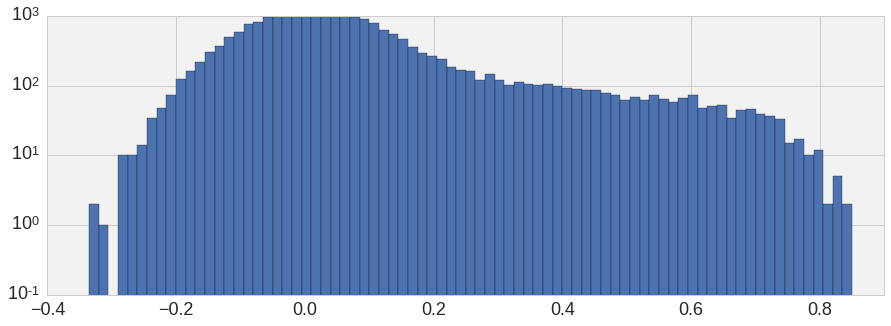

In [14]:
print "max cc = %f" % np.max(m1_data_dict['val_cc'])
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, m1_data_dict['val_cc']))

plt.figure(figsize=(15,5))
_=plt.hist(m1_data_dict['val_cc'], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

In [15]:
roi_volume = view_data((64, 64, 18), voxelIDX, voxelROI)
cc_volume = view_data((64, 64, 18), voxelIDX, m1_data_dict['val_cc'], save_to=None)

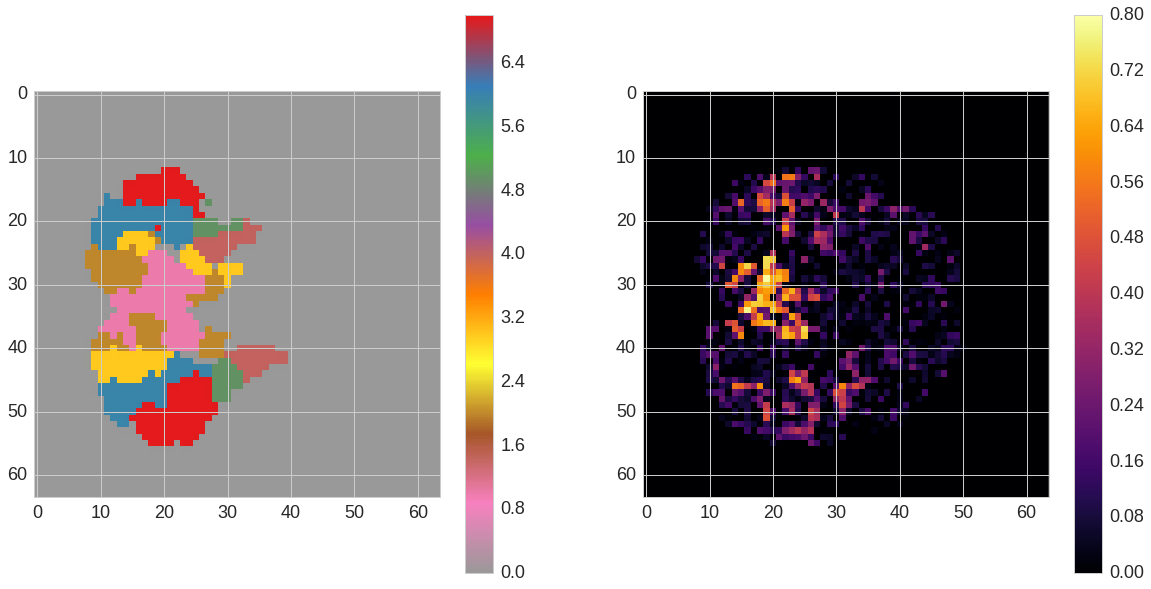

In [16]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(roi_volume[:,:,10], cmap='Set1_r', interpolation='None')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cc_volume[:,:,10], cmap='inferno', interpolation='None')
plt.clim([0,0.8])
plt.colorbar()

# 2b) LOAD THE RESULTS FOR MODEL 2

In [164]:
m2_name = ''
file_name = ''

data_file = open(output_dir + "%s.pkl" % file_name, 'rb')
m2_data_dict = pickle.load(data_file)
data_file.close()
print m1_data_dict.keys()

['fmaps_res_count', 'models', 'fmaps_count', 'dataset', 'grid', 'val_pred', 'scores', 'params', 'subject', 'val_cc', 'model_name', 'fmaps_sizes']


max cc = 0.866229
sum(cc>0.2) = 2746


(-0.4, 0.9)

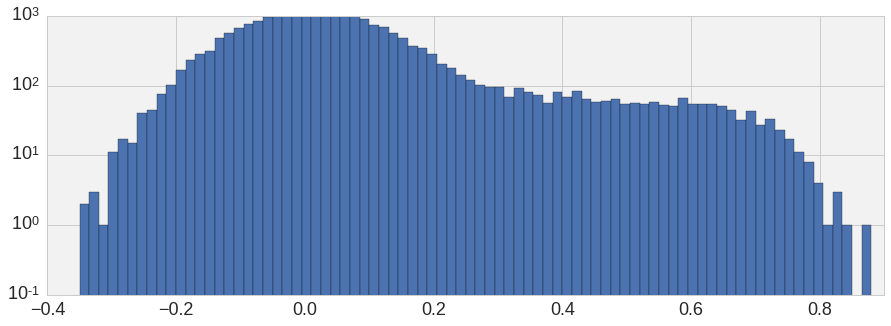

In [176]:
print "max cc = %f" % np.max(m2_data_dict['val_cc'])
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, m2_data_dict['val_cc']))

plt.figure(figsize=(15,5))
_=plt.hist(m2_data_dict['val_cc'], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

In [201]:
roi_volume = view_data((64, 64, 18), voxelIDX, voxelROI)
cc_volume = view_data((64, 64, 18), voxelIDX, m2_data_dict['val_cc'], save_to=None)

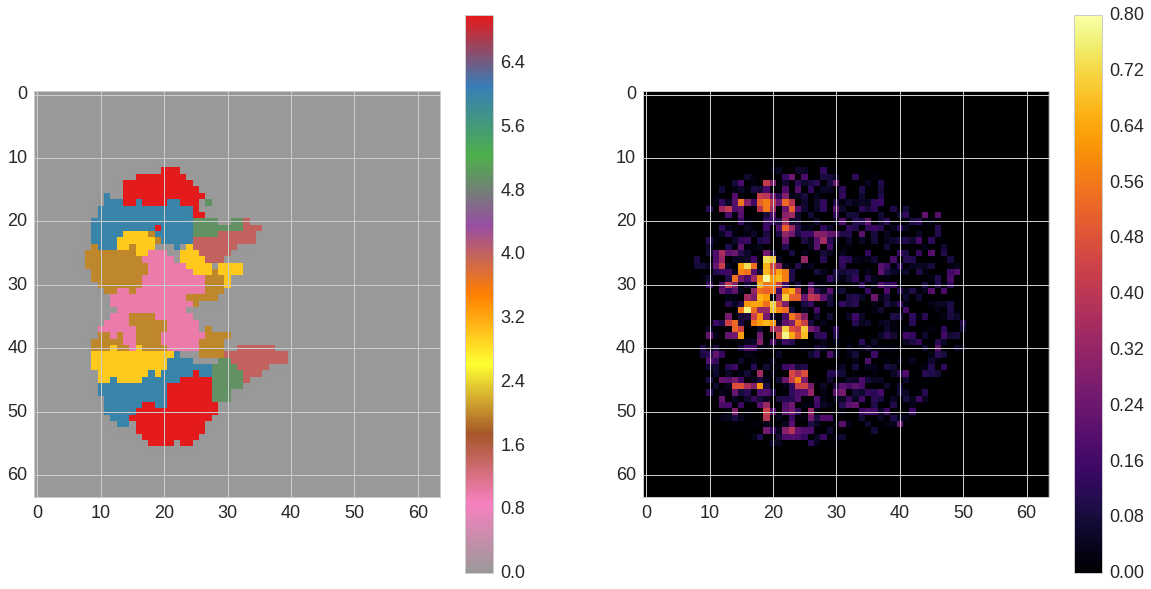

In [202]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(roi_volume[:,:,10], cmap='Set1_r', interpolation='None')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cc_volume[:,:,10], cmap='inferno', interpolation='None')
plt.clim([0,0.8])
plt.colorbar()

# Compare the prediction accuracy of the 2 models

In [17]:
from matplotlib.ticker import FormatStrFormatter

def plot_pretty_scatter(X,Y, threshold, xlim, ylim):
    lim = 256.
    start = map(lambda x: 1.*x/lim, (245,236,225)) #oatmeal
    stop = map(lambda x: .5*x/lim, (137,205,187)) #aqua
    cmap = sns.blend_palette([start,stop], as_cmap=True)
    color2 = '#084990'
    color1 = '#3989c1'
    y = (X+Y)/2
    x = (X-Y)
    
    g = sns.JointGrid(x, y, size=8, xlim=xlim, ylim=ylim)
    # marg. plot
    mask = np.logical_or(X>threshold, Y>threshold) #np.where(Xt[1]>threshold)[0]
    _=g.plot_joint(plt.hexbin, bins='log', gridsize=30, cmap='Blues', extent=xlim+ylim)
    ax1=g.ax_marg_x.hist(x[np.logical_and(mask, x<0)],log=True, color=color1, bins=50, range=xlim) #distplot(color=".5",kde=False) #hist_kws={'log':True}
    ax2=g.ax_marg_x.hist(x[np.logical_and(mask, x>=0)],log=True, color=color2, bins=50, range=xlim) 
    
    adv = np.sum(ax1[0]) / (np.sum(ax1[0])+np.sum(ax2[0]))
    g.ax_marg_x.text(-0.55, 50., '%.2f' % adv, horizontalalignment='left', fontsize=18, color=color1, weight='bold')
    g.ax_marg_x.text( 0.45, 50., '%.2f' % (1.-adv), horizontalalignment='left', fontsize=18, color=color2, weight='bold')
    g.ax_marg_x.set_ylim([0.5, 5e2])
    
    g.ax_marg_x.get_yaxis().reset_ticks()
    g.ax_marg_x.get_yaxis().set_ticks([1e0, 1e1, 1e2])
    g.ax_marg_x.get_yaxis().set_ticklabels([1e0, 1e1, 1e2])
    g.ax_marg_x.set_ylabel('Count', labelpad=10)
    g.ax_marg_x.get_yaxis().grid(True)
    g.ax_marg_x.get_yaxis().set_major_formatter(FormatStrFormatter('%d'))
    g.ax_marg_y.set_visible(False)

    g.ax_joint.plot(np.zeros(len(ylim)), ylim, ':k', lw=2)
    #g.ax_joint.plot(xlim, np.ones(len(xlim)) * threshold, '--r', lw=2)
    g.ax_joint.plot([0., xlim[1]], [threshold, threshold -  xlim[1] / 2], '--r', lw=2)
    g.ax_joint.plot([xlim[0], 0.], [threshold +  xlim[0] / 2, threshold], '--r', lw=2)
    return g

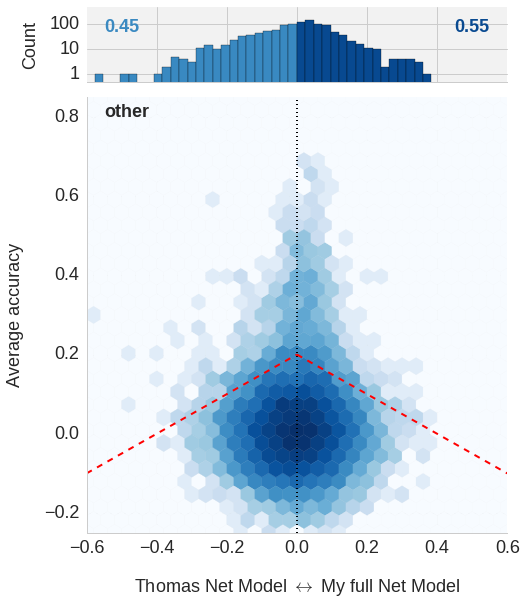

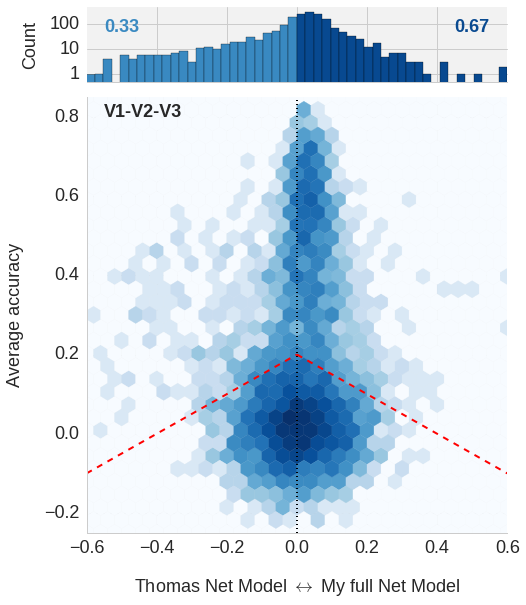

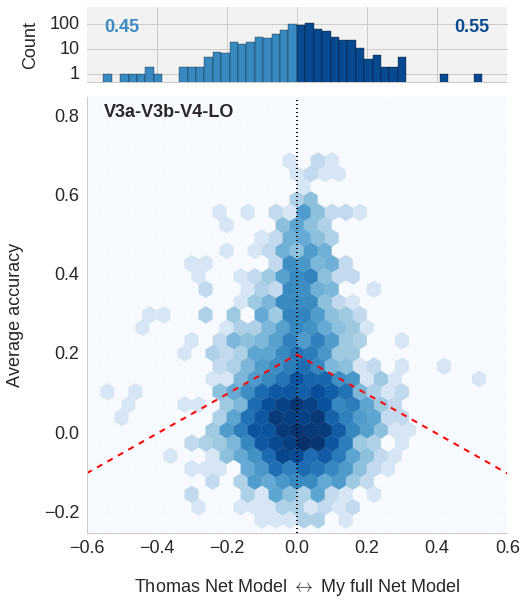

In [208]:
m1_cc = m1_data_dict['val_cc']
m2_cc = m2_data_dict['val_cc']

rg = roi_group2
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    
    fig_1 =plot_pretty_scatter(m1_cc[roi_mask], m2_cc[roi_mask], 0.2, [-.6, .6], [-.25, 0.85])
    plt.xlabel('%s $\leftrightarrow$ %s' % (m2_name, m1_name), labelpad=20)
    plt.ylabel('Average accuracy', labelpad=20)    
    plt.text(-0.55, .8, name, horizontalalignment='left', fontsize=18, weight='bold')
    
    #filename = output_dir + "%s_vs_%s_%s_%s.png" % (m1_name, m2_name, subject, name)
    #fig_1.savefig(filename)
    #plt.close()

# 3) Detailed model analysis

In [18]:
m_name      = m1_name
m_data_dict = m1_data_dict
m_part_dict = m1_part_dict

## 3a) Display RF density in visual field (validated voxels only) and size distribution

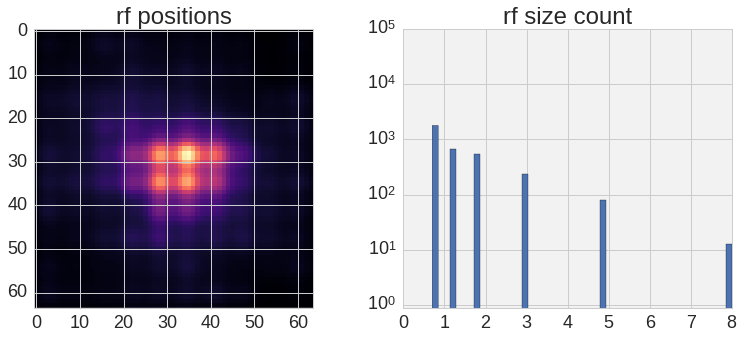

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
cc_mask = m_data_dict['val_cc']>0.2
_,_,g_stack = pnu.make_gaussian_stack(m_data_dict['models'][cc_mask,0], m_data_dict['models'][cc_mask,1], m_data_dict['models'][cc_mask,2], 64, size=20., dtype=np.float32)
plt.imshow(np.sum(g_stack, axis=0), cmap='magma', interpolation='None')
plt.title('rf positions')
plt.subplot(1,3,2)
_=plt.hist(m1_data_dict['models'][cc_mask,2], bins=50, log=True)
plt.ylim([0.9,1e5])
plt.title('rf size count')

In [23]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def circleplot(rfs, smin, smax):
    cNorm  = colors.Normalize(vmin=smin, vmax=smax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('cubehelix_r') )
    print scalarMap.get_clim()
    for rf in rfs:
        colorVal = scalarMap.to_rgba(rf[2])
        c = plt.Circle((rf[0], rf[1]), rf[2], color=colorVal, fill=False, lw=0.7)
        plt.gca().add_artist(c)
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.xlabel('x (degree)')
    plt.ylabel('y (degree)', labelpad=0)
    plt.gca().set_aspect('equal')
    
from scipy.stats import rv_discrete
_pruning_dist = lambda x: rv_discrete(name='custm', values=([0,1], [x, 1-x]))
pruning_dist = _pruning_dist(1.)

5 1
(-0.80000001192092896, 8.0)
(-0.80000001192092896, 8.0)
(-0.80000001192092896, 8.0)
(-0.80000001192092896, 8.0)
(-0.80000001192092896, 8.0)


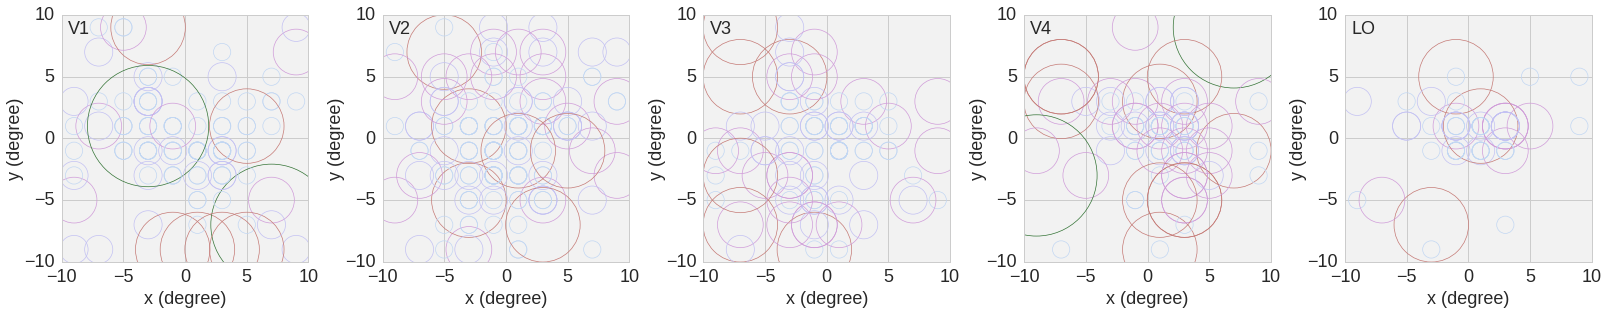

In [27]:
rg = roi_group4
nROI = len(rg)
prune_frac = 0.75
pruning_dist = _pruning_dist(prune_frac)

cc_mask = m_data_dict['val_cc']>0.2
rand_mask = pruning_dist.rvs(size=cc_mask.shape)

smin, smax = np.amin(m_data_dict['models'][:,2])-1.5, np.amax(m_data_dict['models'][:,2])

yROI = nROI // 5
xROI = int(np.ceil(np.float(nROI) / yROI))
print xROI, yROI

fig_3a = plt.figure(figsize=(5*xROI,5*yROI))
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    plt.subplot(yROI,xROI,roi+1)
    plt.subplots_adjust(left=.1, bottom=.1, right=.95, top=.95, wspace=.3, hspace=0.)

    circle_mask = np.logical_and(rand_mask, np.logical_and(roi_mask, cc_mask))
    circleplot(m_data_dict['models'][circle_mask], smin, smax)   
    
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.text(-9.5, 8.5, name, horizontalalignment='left', fontsize=18)

## 3b) Estimate eccentricity and pooling size (if possible)

In [52]:
nk = np.array([55., 27., 13., 13., 13., 1.]) # number of spatial unit for each layer
Pk = np.array([11./227, 51./227, 99./227, 131./227, 163./227, 1.]) # maximum pooling size
print Pk

ecc = np.sqrt(np.square(m_data_dict['models'][:,0])+np.square(m_data_dict['models'][:,1]))
env  = Pk * 10. # estimate pooling size (in degree)

[ 0.04845815  0.2246696   0.43612335  0.57709251  0.71806167  1.        ]


## 3c) Display the feature pooling size per ROI as a function of eccentricity

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]


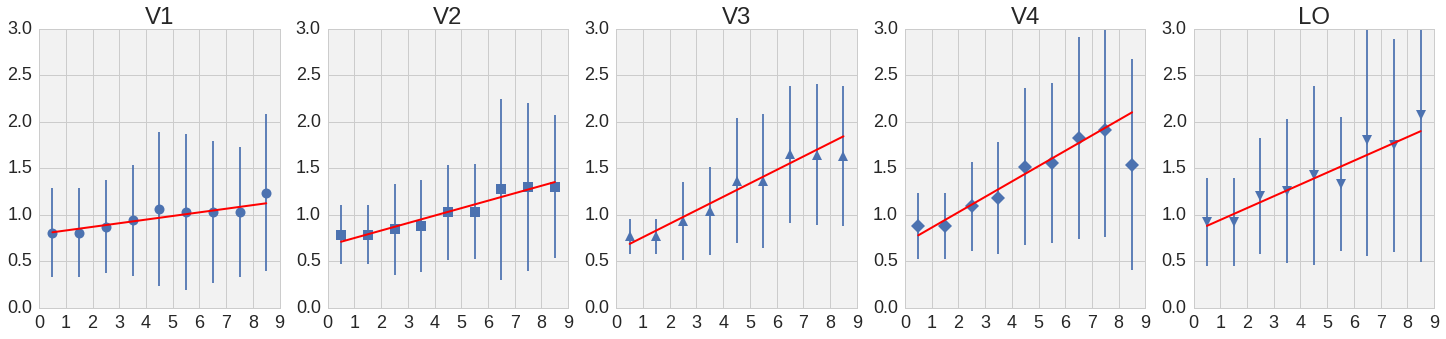

In [65]:
from scipy.optimize import curve_fit
def pooling_area(x, a, b):
    return a*x**1+b #**(1+b)

rg = roi_group4
nROI = len(rg)
cc_mask = m_data_dict['val_cc']>0.2

delta = 1.
width = 2*delta
span = 8.
fit_up_to = [8, 8, 8, 7, 8]
bins = np.linspace(0, span, span/delta+1)
print bins

center   = np.ndarray(shape=(len(bins)))
avg_size = np.ndarray(shape=(nROI, len(bins)))
std_size = np.ndarray(shape=(nROI, len(bins)))

A = []
plt.figure(figsize=(5*nROI,5)) 
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    for i,d in enumerate(bins):
        center[i] = (2*d+delta) / 2
        mask = np.logical_and(np.logical_and(np.logical_and(ecc>d, ecc<=d+width), roi_mask), cc_mask)
        values = m_data_dict['models'][mask,2]
        
        avg_size[roi, i] = np.mean(values)
        std_size[roi, i] = np.std(values)
    
    plt.subplot(1,nROI,roi+1)
    plt.errorbar(center, avg_size[roi], std_size[roi], marker=roi_markers[roi], markersize=10, linestyle='none')
    
    if(np.isnan(np.sum(avg_size[roi]))==False):
        a = curve_fit(pooling_area, center[:fit_up_to[roi]], avg_size[roi, :fit_up_to[roi]])
        A += [a,]
        pooling_area_fn = np.vectorize(lambda x: pooling_area(x, a[0][0], a[0][1])) 
        plt.plot(center, pooling_area_fn(center), color='r', lw=2)    
        plt.ylim(0.0, 3.0)
    else:
        A += [[[0, 0]],]
    plt.title(name)

(0.5, 2.5)

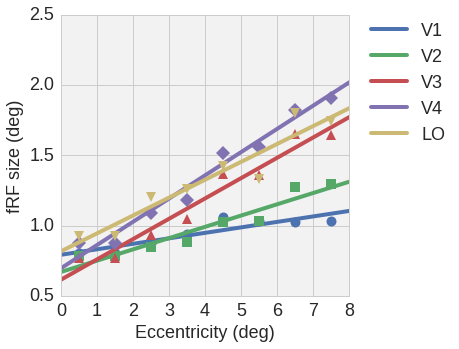

In [31]:
fig_3c1 = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.subplots_adjust(left=.2, bottom=.2, right=.7, top=.85, wspace=0., hspace=0.)
reg = np.arange(0., 11., .5)

for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):
    roi_mask, name = value
    p = plt.plot(center, avg_size[roi], marker=roi_markers[roi], markersize=10, linestyle='none')
    pooling_area_fn = np.vectorize(lambda x: pooling_area(x, A[roi][0][0], A[roi][0][1]))
    plt.plot(reg, pooling_area_fn(reg), color=p[0].get_color(), lw=4, label=name)  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Eccentricity (deg)')
plt.ylabel('fRF size (deg)')
plt.xlim(0,8)
plt.ylim(0.5, 2.5)

In [32]:
filename = output_dir + "%s_summary_frf_size.png" % m_name
fig_3c1.patch.set_alpha(0.)
fig_3c1.savefig(filename)
plt.close()

### Estimate for pRFs

In [56]:
pRF = np.sqrt(np.square(env[np.argmax(m_part_dict['val_ri'], axis=0).astype(int)])+ np.square(m_data_dict['models'][:,2]))
#pRF = np.sqrt(np.square(np.sum(env[:,np.newaxis] * m_part_dict['val_ri'], axis=0) / m_data_dict['val_cc']) + np.square(m_data_dict['models'][:,2]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]


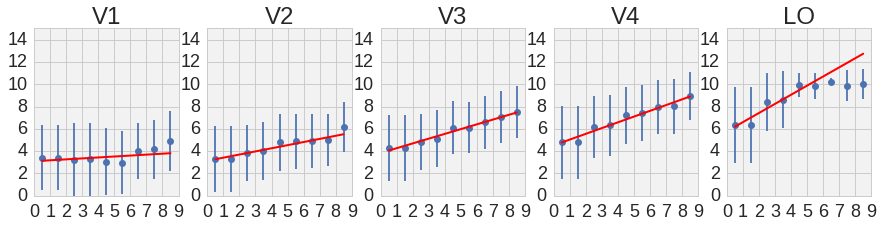

In [61]:
rg = roi_group4
nROI = len(rg)
cc_mask = m_data_dict['val_cc']>0.2

delta = 1.
width = 2*delta
span = 8.
fit_up_to = [8, 8, 8, 8, 6]
bins = np.linspace(0, span, span/delta+1)
print bins

center   = np.ndarray(shape=(len(bins)))
avg_size = np.ndarray(shape=(nROI, len(bins)))
std_size = np.ndarray(shape=(nROI, len(bins)))

A = []
these_roi_names = []
plt.figure(figsize=(3*nROI,3))
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    these_roi_names += [name,]
    for i,d in enumerate(bins):
        center[i] = (2*d+delta) / 2
        mask = np.logical_and(np.logical_and(np.logical_and(ecc>d, ecc<=d+width), roi_mask), cc_mask)
        values = pRF[mask]
        
        avg_size[roi, i] = np.mean(values)
        std_size[roi, i] = np.std(values)
        
    plt.subplot(1,nROI,roi+1)
    plt.errorbar(center, avg_size[roi], std_size[roi], marker='o', linestyle='none')
    a = np.polyfit(center[:fit_up_to[roi]], avg_size[roi, :fit_up_to[roi]], 1)
    A += [a,]
    plt.plot(center, a[1]+a[0]*center, color='r', lw=2)
    plt.ylim(0.0, 15.0)
    plt.title(these_roi_names[roi])       

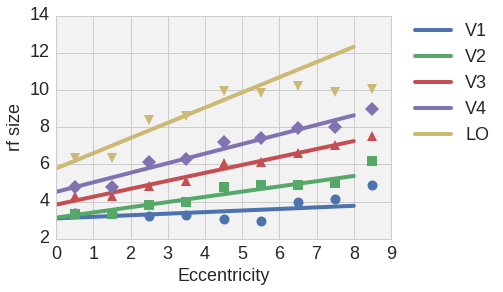

In [62]:
fig_3c2 = plt.figure()
for r in range(nROI):
    p=plt.plot(center, avg_size[r], marker=roi_markers[r], markersize=10, linestyle='none')
    plt.plot(bins, A[r][1]+A[r][0]*bins, lw=4, color=p[0].get_color(), label=these_roi_names[r])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Eccentricity')
plt.ylabel('rf size')

In [63]:
filename = output_dir + "%s_summary_prf_size.png" % m_name
fig_3c2.patch.set_alpha(0.)
fig_3c2.savefig(filename)
plt.close()

## 3d) Parameter analysis (What connects where)

In [40]:
rg = roi_vendrodorsal
nROI = len(rg)
cc_mask = m_data_dict['val_cc']>0.2

L = m1_part_dict['val_ri'].shape[0]
layeridx  = [1, 2, 3, 4, 5, 8] # [1, 2, 3, 4, 5, 6, 7, 8]
layername = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc8'] #['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']

partition_R_avg = np.ndarray(shape=(L, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(L, nROI), dtype=fpX)
these_roi_names = []
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    mask = np.logical_and(roi_mask, cc_mask)
    #mask = np.logical_and(np.logical_and(roi_mask, cc_mask), ecc>=5.)
    these_roi_names += [name,]
    for l in range(L):
        values = m_part_dict['val_ri'][l, mask] /  m_data_dict['val_cc'][mask]
        partition_R_avg[l,roi] = np.mean(values)
        partition_R_std[l,roi] = np.std(values)

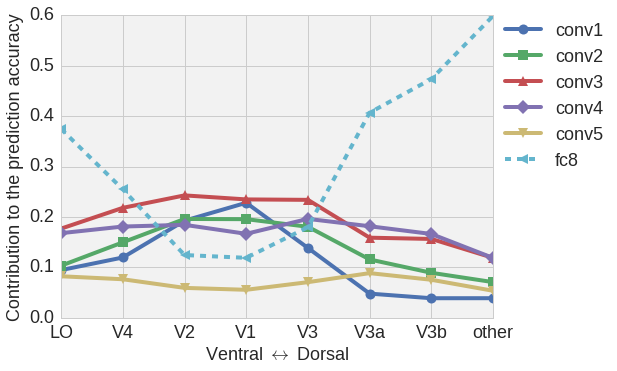

In [41]:
fig_3d1 = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
plt.subplots_adjust(left=.2, bottom=.2, right=.8, top=.9, wspace=.1, hspace=.1)

vrel = partition_R_avg[0][3] # + vrel - v[3]
for l, v in enumerate(partition_R_avg):
    plt.plot(v[:], label=layername[l], lw=4, marker=roi_markers[l], markersize=10, linestyle='dashed' if l>4 else 'solid')
plt.legend(bbox_to_anchor=(1.01, 1), loc=0, borderaxespad=0)
ax.set_xticklabels(these_roi_names)
plt.xlabel('Ventral $\leftrightarrow$ Dorsal')
plt.ylabel('Contribution to the prediction accuracy')

In [42]:
filename = output_dir + "%s_layer_ventrodorsal_soft_connections_plot.png" % m_name
fig_3d1.patch.set_alpha(0.)
fig_3d1.savefig(filename)
plt.close()

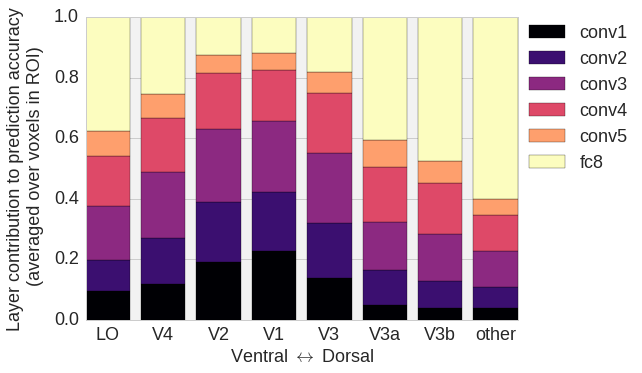

In [45]:
color=iter(cm.magma(np.linspace(0,1,L)))

fig_3d2 = plt.figure(figsize=(10,6))
plt.subplot(111)
plt.subplots_adjust(left=.2, bottom=.2, right=.8, top=.9, wspace=.1, hspace=.1)
c=next(color)
plist = [] #  yerr=partition_R_std[0,:],
_ = plt.bar(np.arange(len(these_roi_names)), partition_R_avg[0,:], color=c, align='center')
plist += [_,]
for l in range(1,L):
    c=next(color)
    _= plt.bar(np.arange(len(these_roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), color=c,\
        align='center', tick_label=these_roi_names)
    plist += [_,]
plt.legend(plist, ['%s' % layername[l] for l in range(len(plist))], bbox_to_anchor=(1.01, 1), loc=0, borderaxespad=0)
plt.ylim([0,1])
plt.xlabel('Ventral $\leftrightarrow$ Dorsal')
plt.ylabel('Layer contribution to prediction accuracy\n (averaged over voxels in ROI)', labelpad=10)

In [46]:
filename = output_dir + "%s_layer_ventrodorsal_soft_connections_bar.png" % m_name
fig_3d2.patch.set_alpha(0.)
fig_3d2.savefig(filename)
plt.close()

## 3e) Layer tuning

In [47]:
rg = roi_group4 #roi_vendrodorsal
nROI = len(rg)
cc_mask = m_data_dict['val_cc']>0.2

partition_R_avg = np.ndarray(shape=(L, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(L, nROI), dtype=fpX)
these_roi_names = []
for roi, value  in enumerate(iterate_roi(rg, voxelROI.flatten(), roi_names)):          
    roi_mask, name = value
    mask = np.logical_and(roi_mask, cc_mask)
    #mask = np.logical_and(np.logical_and(roi_mask, cc_mask), ecc<5.)
    these_roi_names += [name,]
    for l in range(L):
        values = m_part_dict['val_ri'][l, mask] /  m_data_dict['val_cc'][mask]
        partition_R_avg[l,roi] = np.mean(values)
        partition_R_std[l,roi] = np.std(values)

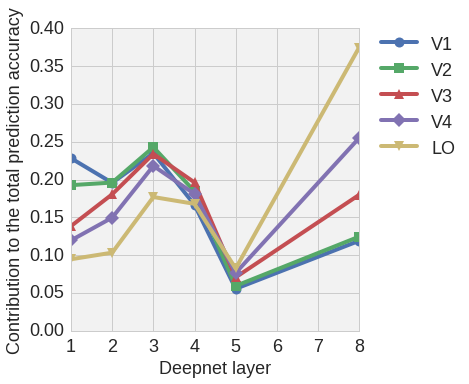

In [48]:
fig_3e = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.subplots_adjust(left=.2, bottom=.2, right=.7, top=.9, wspace=.1, hspace=.1)
for r in range(nROI):
    #plt.plot(freq, partition_R_avg[:,r], lw=4, marker='o', color=next(color), label=these_roi_names[r])
    plt.plot(layeridx, partition_R_avg[:,r], lw=4, marker=roi_markers[r], markersize=10, label=these_roi_names[r])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xlabel('Spatial frequency')
plt.ylim([0, 0.4])
plt.xlabel('Deepnet layer')
plt.ylabel('Contribution to the total prediction accuracy')

In [49]:
filename = output_dir + "%s_layer_roi_connections.png" % m_name
fig_3e.patch.set_alpha(0.)
fig_3e.savefig(filename)
plt.close()